In [1]:
#!/usr/bin/env python

'''
CEM counter plot.py: A program measuring the count rate from the channel eletron multiplier and plotting it in real time.
A. J. McCulloch, November 2018

####################################################################################################

Largely built from previous code; however a useful resource is given below:
Parts taken from https://github.com/MarcoForte/PyDAQmx_Helper/blob/master/pydaqmx_helper/counter.py
'''

####################################################################################################
# Import modules
####################################################################################################

from PyDAQmx import * #PyDAQmx module for working with the NI DAQ
import ctypes #Module required for creating C type ojects - required for some PyDAQmx operations
import time #Time access and conversions
import zmq # Used for ZeroMQ distributed messaging (TCP interface with high-finesse wavemeter)
from pylab import * #For interactive calculations and plotting
from CFIBfunctions import * #Function definitions

####################################################################################################
# Define classes
####################################################################################################

# A mysterious class which seems to be required for live plotting (legacy code from R. Speirs, 2018)
class DataSaver:
    """ I just needed to be able to access an array inside some strange matplotlip function """
    def __init__(self, data = []):
        self.data = data

####################################################################################################
# AOsimple class for simple analogue output
class AOsimple:
    #Initialise the analogue out task
    def __init__(self, ao_physchan = NI_hardware_addresses['AO01'], V_default = 0):
        self.task = Task() #Define the task as Task()
        self.ao_physchan = ao_physchan #Define the analogue output physical channel
        self.voltage = V_default #Set the default voltage
        self.task.CreateAOVoltageChan(ao_physchan,"",-10.0,10.0,DAQmx_Val_Volts,None) #Set the analogu output task

    #Set the AO voltage
    def setvoltage(self, value, confirm = False):
        #Write the voltage
        self.task.WriteAnalogF64(1,1,10.0,DAQmx_Val_GroupByChannel,array(float(value)),None,None)
        #Update the voltage attribute
        self.voltage = value
        #Print a confimation if required
        if confirm == True:
            #Figure out which AO channel is being addressed
            chan = keyfromvalue(NI_hardware_addresses, self.ao_physchan)
            print("Channel {} was set to {} V".format(chan, value))

    #Clear the task
    def clear(self, zero = True, quiet = False):
        #Zero the channel
        if zero == True:
            self.setvoltage(0, True)
        #Clear the task
        self.task.ClearTask()
        if quiet == False:
            print("Analogue output task cleared")

####################################################################################################
# AIsimple class for simple analogue input reading
class AIsimple:
    def __init__(self, samples = 10, sample_rate = 10000, ai_physchan = NI_hardware_addresses['AI01'], read_most_recent = False):
        self.task = Task() #Define the task as Task()
        self.samples = samples #Number of samples per channel
        self.sample_rate = sample_rate #Sampling rate of the analogue input
        self.ai_physchan = ai_physchan #Physical address of the analogue input channel
        self.read = ctypes.c_int32() #Make a ctype to store the measurement
        self.data = np.zeros(self.samples, dtype=np.float64) #Make a data array
        self.task.CreateAIVoltageChan(self.ai_physchan, '', DAQmx_Val_Cfg_Default, -10.0, 10.0, DAQmx_Val_Volts, None) #Create the AI task
        self.buffer_size = 10000 #NOTE: Infrequent measurement/insufficient buffer size will cause overflow!
        self.task.CfgSampClkTiming('', self.sample_rate, DAQmx_Val_Rising, DAQmx_Val_ContSamps, self.buffer_size) #Set the sampling of the task
        #This is legacy code (R. Speirs, 2018), not certain of functionality
        if read_most_recent:
            self.task.SetReadRelativeTo(DAQmx_Val_MostRecentSamp)#be careful with this. Depends what you want to do.
            #self.task.SetReadOffset(-self.samples)

    #Measure the analogue input. Task is started and stopped to avoid buffer overflow
    def readvoltage(self, returnmean = True):
        #Start the task
        self.task.StartTask()
        #Perform the measurement
        self.task.ReadAnalogF64(self.samples, 10.0, DAQmx_Val_GroupByScanNumber, self.data, self.data.size, ctypes.byref(self.read), None)
        #Return the mean of the measured values
        if returnmean == True:
            toreturn = self.data.mean()
        #Retrun an array of measured values
        elif returnmean == False:
            toreturn = self.data
        #Stop the task
        self.task.StopTask()
        return toreturn

    #Clear the task
    def close(self, quiet = False):
        self.task.ClearTask()
        if quiet == False:
            print("Analogue input task cleared")
        elif quiet == True:
            pass

####################################################################################################
# Counter class for defining counter objects
class Counter:
    #Initialise the counting task
    def __init__(self, ctr_physchan = NI_hardware_addresses['Counter 1']):
        self.ctr_physchan = ctr_physchan #Define the physical channel for the coutner
        self.task = Task() #Define the task as Task()
        self.task.CreateCICountEdgesChan(ctr_physchan, '', DAQmx_Val_Rising, 0, DAQmx_Val_CountUp) #Set the counting task
        self.cnt = (ctypes.c_ulong*4)() #Initialise the count - must be unsigned long!
        ctypes.cast(self.cnt, ctypes.POINTER(ctypes.c_ulong))  #Use ctypes cast to constuct a pointer
        self.count = 0 #The most recent count measurement
        self.freq = 0 #The most recent frequency measurement
        self.time = time.time() #Time of the last measurement

    #Start the counter
    def start(self):
        #count_data = (ctypes.c_ulong*1)()
        #ctypes.cast(count_data, ctypes.POINTER(ctypes.c_ulong))
        self.task.StartTask()
        print("DAQ is armed and counting...")

    #Return a count without stopping the counter
    def getCount(self, totalcount = False, sample_rate = 0, samples = 1):
        #Initialise list
        meas = []
        #Perform measurement to initialise the attributes
        self.task.ReadCounterScalarU32(10.0, self.cnt, None)
        #Update the count attribute
        self.count = self.cnt[0]
        #Update the time attribute
        self.time = time.time()
        #Include a pause to allow for sampling at a particular rate
        if sample_rate > 0:
            time.sleep(1/sample_rate)
        #Loop over the number of samples
        for i in range(samples):
            #Read the counter
            self.task.ReadCounterScalarU32(10.0, self.cnt, None)
            #Update the time attribute
            self.time = time.time()
            #Return either the total count (from start) or since last measurement
            #Option 1: The counts since start
            if totalcount == True:
                value = self.cnt[0]
            #Option 2: The coutns since last count measurement (default)
            elif totalcount == False:
                #Difference between the measured count (since start) and previous measurment (since start)
                value = self.cnt[0] - self.count

            #Update the count attribute
            self.count = self.cnt[0]
            #Append the measured value
            meas.append(int(value))
            
            #Include a pause to allow for sampling at a particular rate
            if sample_rate > 0:
                time.sleep(1/sample_rate)
        if samples == 1:
            meas = meas[0]
        return meas

    #Return a frequency without stopping the counter
    def getfreq(self, sample_rate = 0, samples = 1):
        #Initialise list
        meas = []
        #Perform measurement to initialise the attributes
        self.task.ReadCounterScalarU32(10.0, self.cnt, None)
        #Update the count attribute
        self.count = self.cnt[0]
        #Update the time attribute
        self.time = time.time()
        #Include a pause to allow for sampling at a particular rate
        if sample_rate > 0:
            time.sleep(1/sample_rate)
        #Loop over the number of samples
        for i in range(samples):
            #Time since last measurement
            t_old = self.time
            #Read the counter
            self.task.ReadCounterScalarU32(10.0, self.cnt, None)
            #Update the time attribute
            self.time = time.time()
            #Difference between the measured count (since start) and previous measurment (since start)
            numcounts = self.cnt[0] - self.count
            #Calculate the count rate
            value = numcounts/(self.time-t_old)
            #Update the count attribute
            self.freq = value
            #Update the count attribute
            self.count = self.cnt[0]
            #Append the measured value
            meas.append(value)
            #Include a pause to allow for sampling at a particular rate
            if sample_rate > 0:
                time.sleep(1/sample_rate)
                
        if samples == 1:
            meas = meas[0]
        return meas

    #Stop the counter and return the count
    def stop(self, totalcount = False):
        #Get the counter value
        value = self.getCount(totalcount)
        #Stop the task
        self.task.StopTask()
        print("DAQ is armed but no longer counting")
        return value

    #Stop the counter and clear the task
    def close(self):
        self.task.StopTask()
        self.task.ClearTask()
        print("DAQ is no longer armed and tasks have been cleared")

####################################################################################################
# wavemeter class for defining objects to interface with a high-finesse wavemeter 
        
class wavemeter:
    
    # Initialise the wavemeter polling object
    def __init__(self, address, port = '5678'):
        self.address = address # LAN address for TCP polling (IP address of wavemeter machine)
        self.port = port # Port for TCP polling
        self.wavelength = None # Last measured wavelength
        self.ctx = zmq.Context() # Create a ZMQ Context
        self.sub = ctx.socket(zmq.SUB) # Set the ZMQ socket object
        self.poller = zmq.Poller() # Create a poller
        
    # Initialise the subscription 
    #@staticmethod
    def initialise(self):
        self.sub.setsockopt(zmq.SUBSCRIBE, b'L1') # Set the SUB socket to the 'data' topic (needs to be a byte string!)
        self.sub.connect('tcp://' + self.address + ':' + self.port) # Point to the publisher (currently on the atomchumps network)
        self.poller.register(sub, zmq.POLLIN) # Set a ZMQ socket for monitoring
    
    # Return the current wavelength
    def getwavelength(self, verbose = False):
        # Confirm that the wavelength is being queried
        if verbose == True:
            print("Listening for publications")
        
        # Need to ensure that the queue has been flushed before retrieving wavelength
        while True: # Flush
            poll_dict = dict(poller.poll(0)) # Get the data from the poll
            if sub in poll_dict and poll_dict[sub] == zmq.POLLIN:
                # recieve message straight away just to remove it from the queue
                sub.recv_multipart()
            else: # Retrieve
                # when there is nothing left in the queue, wait for the next message to come through, and use that one
                msg = sub.recv_multipart() # Get the message
                self.wavelength = float(bytes.decode(msg[1])) # Extract the wavelength and update the lambda attribute
                if verbose == True:
                    print("Retrieved wavelength: {} nm".format(self.wavelength))
                break # Stop looking for broadcasts
                
####################################################################################################
# Define functions
####################################################################################################
        
####################################################################################################
# Functions for performing ramps

# Generate a linear array of length points between minval and maxval
def makeramp(minval, maxval, points):
    ramp = np.linspace(minval, maxval, points)
    return ramp

# Execute an AO ramp on a channel, ranging between [minval, maxval] in points steps. Dwell and slew are ramp parameters and showplot is for visualisation
def executeAOramp(channel, minval, maxval, points, dwell, slew = 0, slewpoints = 5, showplot = True):
    # Generate the AO task
    try:
        # This will restart cleared tasks
        if str(rampAO.task) == 'Invalid or cleared Task': # rampAO returns a PyDAQmx.Task.Task object (not a string)
            rampAO = AOsimple(channel) # Make the task
    except NameError:
        # This will start new tasks
        rampAO = AOsimple(channel) # Make the task
    # Generate the required voltage ramp to feed to the AO
    vramp = makeramp(minval, maxval, points)
    vramp = np.insert(vramp, 0, 0) # Insert a zero start value
    vramp = np.append(vramp, 0) # Append a zero end value

    # Ramp parameters
    dwelltime = dwell # Dwell time during wavelength scan
    slewtime = slew # Time for slewing between setpoints
    steptime = dwelltime + slewtime # Total time for a step (dwell and slew)
    
    if showplot == True:       
        # Generate ramp plot
        longramp = vramp # Make a copy of the ramp to augment with a slew
        fullramp = [] # Initialise the array to store the time/voltage array
        # Loop over the voltage set points to add a slew to the next ramp setpoint at the end
        for i in range(len(longramp)-1):
            vslew = list(zip(steptime * i + makeramp(0, slewtime, slewpoints),makeramp(longramp[i],longramp[i+1], slewpoints)))
            fullramp.extend(vslew)

        v, t = zip(*fullramp) # Make lists for plotting
        # Make the plot
        plt.step(v, t, where = 'post')
        plt.xlabel('Time [s]')
        plt.ylabel('Voltage [V]')
        plt.show()

    # Ramp the laser wavelength 
    # Set ramp voltage and wait for a dwell time before changing
    # Case 1: no slew. Simple ramp and pause
    if slew == 0:
        for voltage in vramp:
            rampAO.setvoltage(voltage) # Set the AO voltage
            time.sleep(dwelltime) # Don't do anything for a time = dwelltime
    # Case 2: non-zero slew. Generate ramp between set points, ramp the (slew) voltage and then pause
    elif slew > 0:
        for i in range(len(vramp)-1):
            toset = makeramp(vramp[i],vramp[i+1], slewpoints) # Create ramp between set points
            for voltage in toset:
                rampAO.setvoltage(voltage) # Set the AO voltage
                time.sleep(slewtime/(slewpoints-1)) # Don't do anything for a time = slewtime/(slewpoints-1)
            time.sleep(dwelltime) # Don't do anything for a time = dwelltime
                
    print("Ramp completed, reseting voltage and clearing task")
    rampAO.setvoltage(0) # Zero the AO voltage (otherwise laser will have an offset)
    
    rampAO.clear(zero = False, quiet = True) #Clear the AO task (and zero the AO)
        
####################################################################################################
#Create a dynamically updating plot
def makeplot():
    t_span = 5
    t_points = 200

    fig1, ax1 = plt.subplots(1, 1, tight_layout=True)
    line, = ax1.plot(linspace(-t_span, 0, t_points), zeros(t_points))
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Count rate (Hz)')
    ax1.set_ylim(0, 2000)
    ax1.set_xlim(-5, 0)
    ax1.set_title('CEM count rate')
    ax1.grid()

    #Plot the ion rate in real time
    sample_rate = t_points/t_span
    read_rate = 20 #this is only approx. would be 50ms plot update rate
    samples = int(sample_rate/read_rate)

    #Initialise the counts
    CEM_counts = Counter(NI_hardware_addresses['Counter 2'])
    #Start the counter
    CEM_counts.start()

    saved = DataSaver()
    saved.data_save = zeros(t_points)

    def update_data(update_number):
        #roll left to right
        saved.data_save = roll(saved.data_save, -samples)
        saved.data_save[-samples:] = CEM_counts.getfreq(sample_rate, samples)
        line.set_ydata(saved.data_save)  # update the data
        return line,

    import matplotlib.animation as animation
    print('Plotting transmission photodiode voltage. Close figure to end.')
    ani = animation.FuncAnimation(fig1, update_data, interval=int(read_rate/2), blit=True)
    plt.show()

####################################################################################################
####################################################################################################
#Code starts here
####################################################################################################
####################################################################################################

## Development and testing

In [ ]:
executeAOramp(channel, minval, maxval, points, dwell, slew = 0, slewpoints = 5, showplot = True)

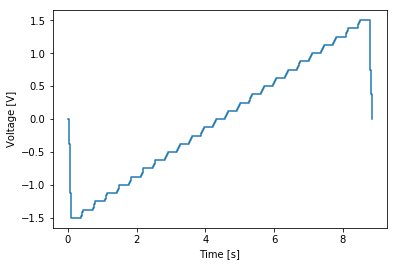

Ramp completed, reseting voltage and clearing task


In [2]:
executeAOramp(NI_hardware_addresses['AO02'], -1.5, 1.5, 25, 0.25, 0.1, 5)

# Example usage

### Analogue output

In [ ]:
#Create the AO task
analogueout = AOsimple(NI_hardware_addresses['AO01'])
#Set the AO voltage
analogueout.setvoltage(2.5, True)

In [ ]:
#Clear the AO task (and zero the AO)
analogueout.clear()

### Analogue input

In [22]:
#Create the AI task
analoguein = AIsimple(ai_physchan = NI_hardware_addresses['AI31'])
#Read the AI voltage
analoguein.readvoltage()

-0.0005527164634875593

In [ ]:
#Clear the AI task
analoguein.close()

### Counter

In [2]:
# Initialise the counts
CEM_counts = Counter(NI_hardware_addresses['Counter 2'])
# Start the counter
CEM_counts.start()

DAQ is armed and counting...


In [3]:
# Return the count since last count. Set "totalcount = True" for count since start (or look at Counter.count attribute)
CEM_counts.getCount(sample_rate = 20, samples = 10)

[51, 50, 54, 60, 60, 60, 50, 60, 60, 50]

In [4]:
# Return the frequency measured by the counter
CEM_counts.getfreq(sample_rate = 20, samples = 20)

[999.9866487378289,
 1003.7267849089252,
 980.7016395282499,
 1019.0388589558531,
 1000.1122282716688,
 999.0719832309085,
 999.1338608936765,
 992.3013905374924,
 1000.2791866066744,
 1000.4183611405946,
 999.9246654047328,
 999.7864225781846,
 999.1382476855961,
 999.9691654812331,
 998.8816384853536,
 995.5670333113378,
 1009.1111847510792,
 1000.0804330029646,
 999.8436218700535,
 1009.7262861755307]

In [ ]:
#Stop the counter and return the count 
CEM_counts.stop()

In [ ]:
#Stop the counting task
CEM_counts.close()

### Ramp an analogue voltage

In [ ]:
# Ramp an analogue voltage and return a plot with the expected voltage vs time
executeAOramp(NI_hardware_addresses['AO02'], -1.5, 1.5, 25, 0.25)

In [ ]:
# Ramp an analogue voltage with a slew for stabilisation and return a plot with the expected voltage vs time
executeAOramp(NI_hardware_addresses['AO02'], -1.5, 1.5, 25, 0.25, 0.1, 5)

### Wavelength measurement

In [ ]:
# Define a wavemeter object (requires IP address of wavemeter machine)
lambda_meas = wavemeter('192.168.68.43')
# Initialise the polling of the wavemeter
lambda_meas.initialise()

In [ ]:
# Return the most recent measurement of the wavemeter (with verbose output for print statements)
lambda_meas.getwavelength(verbose = True)

### Live plotting

In [ ]:
#Make a animated plot of the count rate vs time
makeplot()